In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Load the CSV file
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
import math
from scipy.stats import ttest_ind
from statistics import mean, stdev

log_file = "C:\\Users\\ekuep\\Desktop\\ols_logs_aggreg.txt"
csv_file = "C:\\Users\\ekuep\\Desktop\\rsquared_values.csv"
file_path = "Q:\\main_propellab\\Users\\Ng, Gabe\\Summer Student 2024\\Rhythmic Stimulation Gait Similarity Project\\Analysis and Results\\Updated_DataSplitting\\STSR\\STSR_10HMMs_3states_secondbaseline\\logresults_16-07-24_19-52.csv"

In [3]:
#For each participant, applies a regression across change in stance time symmetry to change in similarity score
#Runs through all combinations of algorithms and sensor combinations.

data = pd.read_csv(file_path)
data.columns = ['FilePath', 'Sensor', 'GaitParam', 'Algorithm', 'Participant', 'X', 'Y']
data['X'] = pd.to_numeric(data['X'], errors='coerce')
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')


def percent_difference(values):
    base_value = values.iloc[0]  # Take the first value as base
    return [math.ceil(abs(value - base_value)) for value in values]

def plot_scatter_and_regress(data, algorithm, participant, sensor):
    subset = data[(data['Algorithm'] == algorithm) & 
                  (data['Participant'] == participant) & 
                  (data['Sensor'] == sensor)]
    #print(f'Generating plot and regression for {algorithm}, {participant}, {sensor}, number of data points: {len(subset)}')
    
    if not subset.empty:
        subset['Percent_Difference'] = percent_difference(subset['X'])
        X = subset['Percent_Difference'].values
        subset['Ydiff'] = subset['Y'] - subset['Y'].iloc[0]
        Y = subset['Ydiff'].values
        subset_df = pd.DataFrame({'X': X, 'Y': Y})
        model = ols('Y~X',data=subset_df)
        results = model.fit()

        # with open(log_file, 'a') as f:
        #     f.write(f'Regression results for {algorithm}, {participant}, {sensor}:\n')
        #     f.write(results.summary().as_text() + '\n\n')
        
        # rsquared = results.rsquared
        
        # with open(csv_file, 'a') as f:
        #     f.write(f'{algorithm},{participant},{sensor},{rsquared}\n')    
            
        # #print(results.summary2())
        # plt.figure()
        # plt.scatter(X, Y, label=f'{algorithm}-{participant}-{sensor}')
        # sns.regplot(x='X',y='Y',data = subset_df,ci=None)
        # plt.text(x=subset_df['X'].min(), y=subset_df['Y'].max(), s=f'$R^2 = {rsquared:.2f}$')
        # plt.xticks(X)
        # plt.ylabel('Change in Similarity')
        # plt.xlabel('% Change in Stance Time Symmetry')
        # plt.title(f'Scatter Plot and Regression for {algorithm}, {participant}, {sensor}')
        # plt.savefig(f'C:\\Users\\ekuep\Desktop\\{algorithm}-{participant}-{sensor}.png')
        
    else:
        print(f'No data available for {algorithm}, {participant}, {sensor}')

participants = data['Participant'].unique()
sensors = data['Sensor'].unique()
algorithms = data['Algorithm'].unique()

for participant in participants:
    for sensor in sensors:
        for algorithm in algorithms:
            plot_scatter_and_regress(data, algorithm, participant, sensor)


C:\Users\ekuep\AppData\Local\Temp\ipykernel_20252\825065659.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Percent_Difference'] = percent_difference(subset['X'])
C:\Users\ekuep\AppData\Local\Temp\ipykernel_20252\825065659.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Ydiff'] = subset['Y'] - subset['Y'].iloc[0]
C:\Users\ekuep\AppData\Local\Temp\ipykernel_20252\825065659.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Generating plot and regression for DTW, pelvis, number of data points: 39
    Baseline          0       0.03       0.06
0  11.880343  11.473294  12.431418       None
1  14.742856  15.083722  14.798167  15.714489
2   9.742027   9.596731   9.510447   9.630187
3  12.912325  13.200713  13.113735   13.33553
4  17.937345  17.558468  17.798274   18.08382
5  17.315116  17.425829  17.717107  17.832593
6  12.093611  12.372648  12.187538  13.051699
7   11.98431  12.081159  12.143752  11.183694
8  16.108863   15.57745  15.909573  15.962558
9  16.087561  15.808265  15.103049  15.139613
Generating plot and regression for MDP, pelvis, number of data points: 40
   Baseline         0      0.03      0.06
0  0.886383  0.911534   0.84027   0.81018
1  0.874201  0.860445   0.91231   0.91373
2  0.589525  0.552289  0.557542  0.584865
3  0.780363  0.809522  0.779717   0.79823
4  0.946257  0.930183  1.049318  0.920641
5  0.969434  0.973174  0.953511  1.037276
6  0.765256  0.791951  0.738866  0.762727
7   0.6898

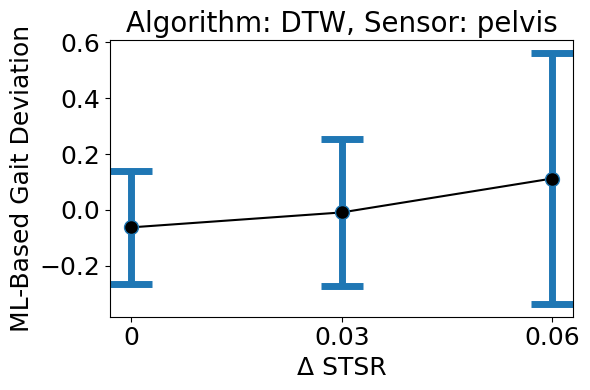

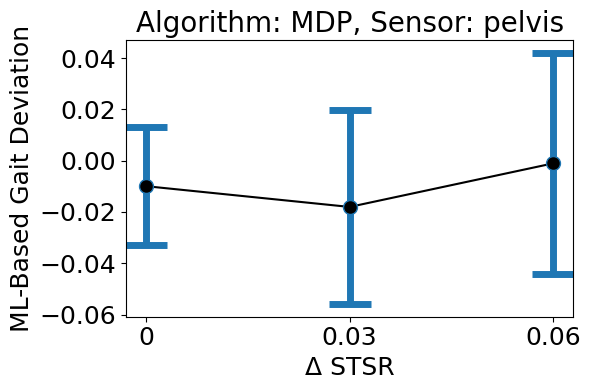

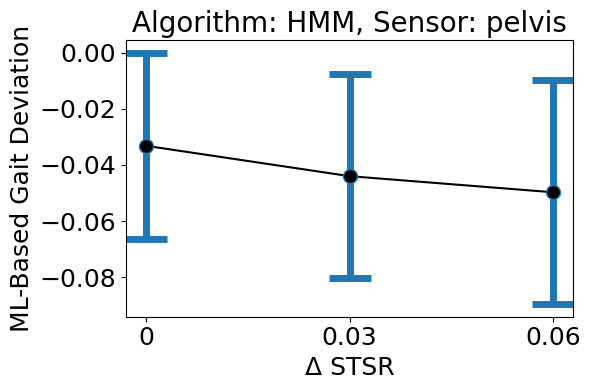

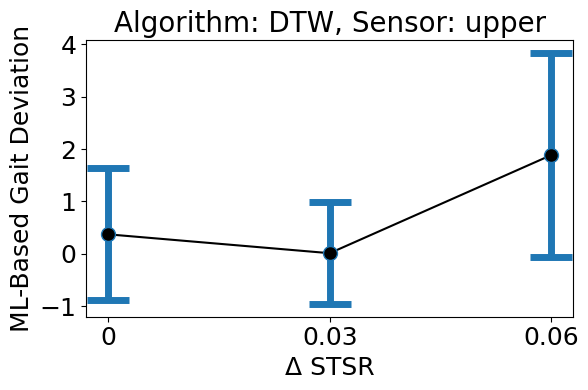

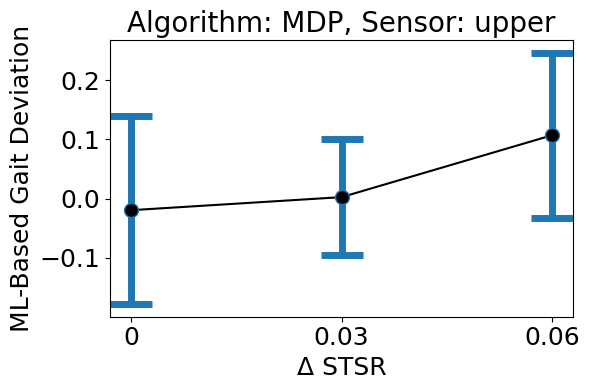

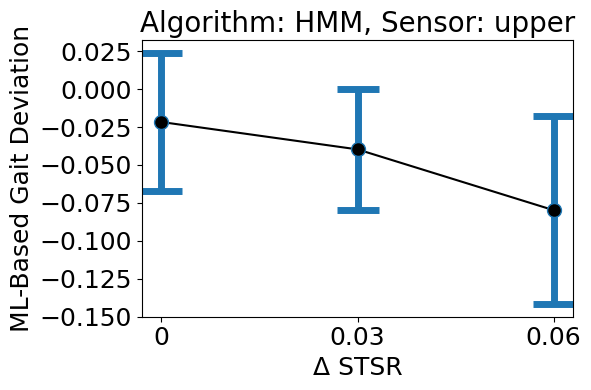

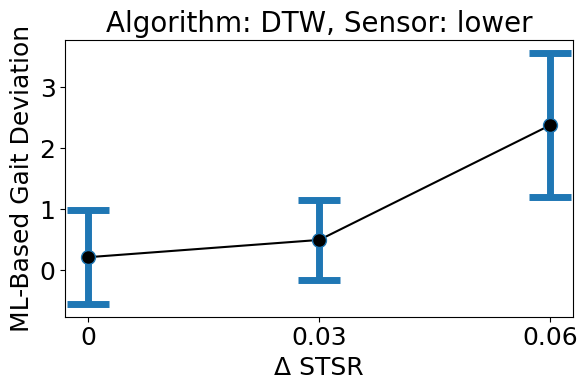

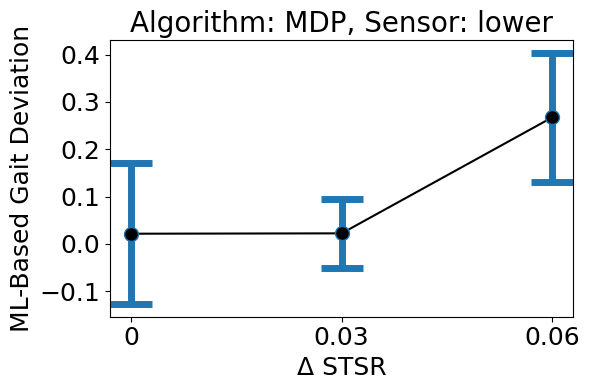

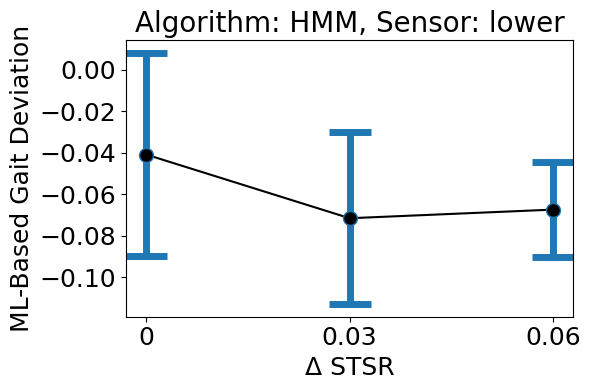

In [6]:
#Aggregates participants together for a given algorithm and sensor config result. Options for computing SRM, Cohen's d, Welch's t-test, etc.
data = pd.read_csv(file_path)
data.columns = ['FilePath', 'Sensor', 'GaitParam', 'Algorithm', 'Participant', 'X', 'Y']
#data['X'] = pd.to_numeric(data['X'], errors='coerce')
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')

def calculate_srm(col1, col2):
    # Filter out None values
    valid_indices = ~col1.isna() & ~col2.isna()
    if np.any(valid_indices):
        mean_diff = np.mean(col1[valid_indices] - col2[valid_indices])
        std_diff = np.std((col1[valid_indices] - col2[valid_indices]),ddof=1)
        return mean_diff / std_diff
    else:
        return np.nan  # Return NaN if no valid values are present

def calculate_cohens_d(group1, group2):
    mean_diff = mean(group1) - mean(group2)
    pooled_std = np.sqrt((stdev(group1)**2 + stdev(group2)**2) / 2)
    return mean_diff / pooled_std

# Function to plot scatter plots and regression
def plot_scatter_and_regress(data, algorithm, sensor, csv_file):
    
    csv_file = "C:\\Users\\ekuep\\Desktop\\SRM_values.csv"
    csv_file2 = "C:\\Users\\ekuep\\Desktop\\ttest_values.csv"
    csv_file3 = "C:\\Users\\ekuep\\Desktop\\CohensD_values.csv"
    
    subset = data[(data['Algorithm'] == algorithm) & 
                  (data['Sensor'] == sensor)]
    print(f'Generating plot and regression for {algorithm}, {sensor}, number of data points: {len(subset)}')
    
    if not subset.empty:
        
        # df = pd.DataFrame(columns=['0', '0.03', '0.06'], index=range(10))  # Initialize outside the loop
        # df2 = pd.DataFrame(columns=['0', '0.03', '0.06'], index=range(10))  # Initialize outside the loop
        
        df = pd.DataFrame(columns=['Baseline', '0', '0.03','0.06'], index=range(10))  # Initialize outside the loop
        df2 = pd.DataFrame(columns=['Baseline', '0', '0.03','0.06'], index=range(10))  # Initialize outside the loop
        for i, participant in enumerate(subset['Participant'].unique()):
            participant_data = subset[subset['Participant'] == participant].copy()
            participant_data['Y_diff'] = participant_data['Y'] - participant_data['Y'].iloc[0]
            Y = participant_data['Y'].values.tolist()
            Y_diff = participant_data['Y_diff'].values.tolist()
            
            # df.loc[i] = Y
            # df2.loc[i] = Y_diff
            if len(Y) == 3:
                df.loc[i] = Y + [None]  # Add None to make it 4 elements
                df2.loc[i] = Y_diff + [None]
            elif len(Y) == 4:
                df.loc[i] = Y
                df2.loc[i] = Y_diff
        
        print(df)
        srm_results = {}
        t_test_results = {}
        cohen_d_results = {}
        
        start_column = 'Baseline'
        for col in df.columns:
            if col != start_column and not df[col].isna().all():  # Ignore '0%' column and columns with all None values
                # Ensure numeric data and drop NaNs
                data1 = df[start_column].dropna().astype(float)
                data2 = df[col].dropna().astype(float)
                
                # Calculate SRM
                srm_value = calculate_srm(data1, data2)
                srm_results[col] = srm_value
                
                # Perform Welch's t-test
                t_stat, p_val = ttest_ind(data1, data2, equal_var=False)
                t_test_results[col] = {'t_statistic': t_stat, 'p_value': p_val}
                
                # Calculate Cohen's d
                cohen_d = calculate_cohens_d(data1, data2)
                cohen_d_results[col] = cohen_d
                       
        #Append results to CSV file
        with open(csv_file, "a") as csv_file:
            for key, value in srm_results.items():
                csv_file.write(f"{algorithm},{sensor},{key},{value}\n") 
        
        with open(csv_file2, "a") as csv_file2:
            for key, value in t_test_results.items():
                csv_file2.write(f"{algorithm},{sensor},{key},{value}\n") 
                
        with open(csv_file3, "a") as csv_file3:
            for key, value in cohen_d_results.items():
                csv_file3.write(f"{algorithm},{sensor},{key},{value}\n") 
        
        #Use the second dataframe for the plotting        
        mean_values = df2.mean()
        sem_values = df2.sem()  # Standard error of the mean
        x_labels = df.columns
        plt.figure(figsize=(6,4))
        # plt.errorbar(x_labels[1:], mean_values[1:], yerr=1.96 * sem_values[1:], fmt='o', capsize=15, linewidth=5,markersize=10,capthick=5) #font size 26 -- option used to generate figures for pres.
        plt.errorbar(x_labels[1:], mean_values[1:], yerr=1.96 * sem_values[1:], fmt='o',capsize=15,linewidth=5,markersize=10,capthick=5,markerfacecolor='black')
        plt.plot(x_labels[1:], mean_values[1:], linestyle='-', color='black')
        plt.xlabel('Δ STSR',fontsize=18)
        plt.ylabel('ML-Based Gait Deviation',fontsize=18)
         #Adjust title based on conditions

        if sensor == "UpperLeg":
            title_sensor = "Upper Leg"
        else:
            title_sensor = sensor
        
        if algorithm == "HMM-SM":
            title_algorithm = "HMM"

        else:
            title_algorithm = algorithm
        plt.title(f"Algorithm: {title_algorithm}, Sensor: {title_sensor}", fontsize=20)
        
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        
        plt.tick_params(axis='y')
        plt.tick_params(axis='x')
        
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.tight_layout()
        plt.savefig(f"C:\\Users\\ekuep\\Desktop\\changefrombaseline_STSR_{algorithm}_{sensor}.png")  # Save plot
        
# Get unique combinations of sensors and algorithms
sensors = data['Sensor'].unique()
algorithms = data['Algorithm'].unique()

# Plot for each combination of sensor and algorithm
for sensor in sensors:
    for algorithm in algorithms:
        plot_scatter_and_regress(data, algorithm, sensor, csv_file)